## Genetic algorithm for FLP and LRP

This algorithm aims to utilize hybrid characteristics to solve the Facility location problem and its extention the location routing problem. The routing component is optional in the algorithm.

In [ ]:
### Library import

import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import time

In [ ]:
### Data import

filename = "instance50.txt"

with open(filename) as f:
    lines = f.readlines()
    NoCustomers = int(lines[0])
    X = []
    Y = []
    Dem = []
    for i in lines[1:]:
        X.append(float(i.split()[0]))
        Y.append(float(i.split()[1]))
        Dem.append(float(i.split()[2]))

        
Xcord = np.asarray(X).reshape(NoCustomers,1)
Ycord = np.asarray(Y).reshape(NoCustomers,1)
Demand = np.asarray(Dem).reshape(NoCustomers,1)


In [ ]:
### Model parameters

NoFacil = 15
NoChromo = 60
NoCross = round(0.33*NoChromo)
NoMut = round(0.33*NoChromo)
NoRem = NoChromo-NoCross-NoMut
mutRate = 0.1 ##Mutation rate == How many chromosomes are mutated
numbMut = 2 ## Genes to be mutated in each mutated chromosome
NumberIter = 50


A1 = round(0.6*NoChromo)
A2 = round(0.3*NoChromo)
A3 = NoChromo-A1-A2


In [ ]:
np.random.seed(100)
ChromoX = np.random.rand(NoChromo,NoFacil)*(max(Xcord)-min(Xcord))
np.random.seed(120)
ChromoY = np.random.rand(NoChromo,NoFacil)*(max(Ycord)-min(Ycord))

#print(ChromoX)
#print("...")
#print(ChromoY)

In [ ]:
def get_Dist(X1,Y1,X2,Y2):
    return math.sqrt(math.pow(X1-X2,2)+math.pow(Y1-Y2,2))

In [ ]:
def Facil_distance(Xcord,Ycord,ChromoX,ChromoY,NoCustomers):
    
    d = np.zeros((NoCustomers))
    for j in range(NoCustomers):
        d[j] = get_Dist(ChromoX,ChromoY,Xcord[j],Ycord[j])
    
    return d

In [ ]:
def Evaluation(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo):
    
    result =np.zeros((NoChromo))
    for i in range(NoChromo):
        d = np.zeros((NoCustomers,NoFacil))
        proximity = np.zeros((NoCustomers))
        
        for j in range(NoFacil):
            A =np.array((Xcord,Ycord))
            B = np.array((ChromoX[i,j],ChromoY[i,j]))
            A = np.reshape(A,(2,NoCustomers))
            B = np.reshape(B,(2,1))
            d[:,j]=np.linalg.norm((A-B),axis=0)
                
                #Facil_distance(Xcord,Ycord,ChromoX[i,j],ChromoY[i,j],NoCustomers)
        
        result[i]=(np.sum(np.multiply(d.min(axis = 1),Dem.T)))
        proximity=(d.argmin(axis=1))

    return result

In [ ]:
def Weiszfeld(Xcord,Ycord,Xcenter,Ycenter,NoCustomers,Dem):
    
    improv = 1 
    epsilon = 10**(-2)
    itermax = 5
    
    Cost = (np.sum(np.multiply(Facil_distance(Xcord,Ycord,Xcenter,Ycenter,NoCustomers),Dem.T)))
    iterat = 0
    while ((improv>epsilon) and (iterat <itermax)):
        iterat=iterat+1
        x = 0
        y = 0
        W = 0
        d = np.zeros((NoCustomers))
        for j in range(NoCustomers):
            d[j] = get_Dist(Xcenter,Ycenter,Xcord[j],Ycord[j])
            if (d[j]!=0):
                w = (1/d[j])*(1/Dem[j])
                x = x+Xcord[j]*w
                y = y+Ycord[j]*w
                W = W +w
        
        if (W!=0):
            X = x/W
            Y = y/W
        else:
            X = x
            Y=y
        New_Cost = (np.sum(np.multiply(Facil_distance(Xcord,Ycord,X,Y,NoCustomers),Dem.T)))
        improv = Cost - New_Cost
        if (improv>epsilon):
            Cost = New_Cost
            Xcenter = X
            Ycenter = Y
    
    return Xcenter,Ycenter
    

In [ ]:
def Cooper_Algorithm(Xcord,Ycord,ChromoX,ChromoY,NoCustomers,NoFacil,Dem):
    
    epsilon = 10**-2
    improvement = 1
    d = np.zeros((NoCustomers,NoFacil))
    proximity = np.zeros((NoCustomers))

    for i in range(NoFacil):
            A =np.array((Xcord,Ycord))
            B = np.array((ChromoX[i],ChromoY[i]))
            A = np.reshape(A,(2,NoCustomers))
            B = np.reshape(B,(2,1))
            d[:,i]=np.linalg.norm((A-B),axis=0)
                
        
    Cost=(np.sum(np.multiply(d.min(axis = 1),Dem.T)))
    proximity=(d.argmin(axis=1))
    
    tmpX = np.copy(ChromoX)
    tmpY = np.copy(ChromoY)


    while (improvement>epsilon):
        
        for j in range(NoFacil):
            #print(tmpX[j],tmpY[j])
            tmpX[j],tmpY[j] = Weiszfeld(Xcord[proximity==j],Ycord[proximity==j],tmpX[j],tmpY[j],sum(proximity==j),Dem[proximity==j])
            #print(tmpX[j],tmpY[j])
        
        d = np.zeros((NoCustomers,NoFacil))
        proximity = np.zeros((NoCustomers))
        for i in range(NoFacil):
            A =np.array((Xcord,Ycord))
            B = np.array((ChromoX[i],ChromoY[i]))
            A = np.reshape(A,(2,NoCustomers))
            B = np.reshape(B,(2,1))
            d[:,i]=np.linalg.norm((A-B),axis=0)
        
        New_Cost=(np.sum(np.multiply(d.min(axis = 1),Dem.T)))
        proximity=(d.argmin(axis=1))
        improvement = Cost - New_Cost
        Cost=New_Cost

    return Cost, tmpX,tmpY

In [ ]:
def Cooper_Evaluation(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo):
    
    
    
    z1 = np.zeros((NoChromo))
    tmpX = np.copy(ChromoX)
    tmpY = np.copy(ChromoY)
    
    t0 = time.time()
    for i in range(NoChromo):
        z1[i],tmpX[i],tmpY[i] = Cooper_Algorithm(Xcord,Ycord,ChromoX[i],ChromoY[i],NoCustomers,NoFacil,Demand)
        #if i % 10 ==0:
         #   print(i)
            
    t1 = time.time()  
    #print(t1-t0)
    return z1,tmpX,tmpY

In [ ]:
def SimpleCrossover(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoCross):
    
    
    CrossX = np.zeros((NoCross,ChromoX.shape[1]))
    CrossY = np.zeros((NoCross,ChromoY.shape[1]))
    
    
    for i in range(NoCross):
        chromo1 = random.randint(0,NoChromo-1)                         ## First parent
        chromo2 = random.randint(0,NoChromo-1)                         ## Second parent
 
        cut = random.randint(0,NoFacil-1)                              ##Cut-off point

        CrossX[i,0:cut] = np.copy(ChromoX[chromo1,0:cut])
        CrossX[i,cut:] = np.copy(ChromoX[chromo2,cut:])
    
        CrossY[i,0:cut] = np.copy(ChromoY[chromo1,0:cut])
        CrossY[i,cut:] = np.copy(ChromoY[chromo2,cut:])
        
    return CrossX, CrossY

In [ ]:
def SimpleMutation(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoMut, mutRate, numbMut):
    
    
    mutX = np.zeros((NoMut,ChromoX.shape[1]))
    mutY = np.zeros((NoMut,ChromoY.shape[1]))

    
    for i in range(NoMut):
        chromo = random.randint(0,NoChromo-1)                         ## hromosome to be mutated
        mutX[i,:]=np.copy(ChromoX[chromo,:])
        mutY[i,:]=np.copy(ChromoY[chromo,:])
        
        genes = (random.sample(range(0, NoFacil-1), numbMut))
        for j in (genes):
            mutX[i,j] = np.random.rand()*(max(Xcord)-min(Xcord))
            mutY[i,j] = np.random.rand()*(max(Ycord)-min(Ycord))

    return mutX, mutY

In [ ]:
def SimpleSurvival(ChromoX,ChromoY,fitness, NoRem):
    beta = 4    ## Hyperparameter

    RemX = np.zeros((NoRem,ChromoX.shape[1]))
    RemY = np.zeros((NoRem,ChromoY.shape[1]))
    CumFit = np.zeros((fitness.shape))
    
    Rev = np.exp(-(beta)*fitness/max(fitness))
    Tot = np.sum(Rev)
    indiv = Rev/Tot
    
    for i in range(len(fitness)):
        if i!=0:
            CumFit[i]=CumFit[i-1]+indiv[i]
        else:
            CumFit[i]=indiv[i]
            
            
    RemX[0,:] = np.copy(ChromoX[np.argmin(fitness)])
    RemY[0,:] = np.copy(ChromoY[np.argmin(fitness)])
    for j in range(1,NoRem):
        ind = np.random.rand()
        count = 0
        if ind<= CumFit[count]:
            RemX[j,:] = np.copy(ChromoX[count])
            RemY[j,:] = np.copy(ChromoY[count])
        else:
            while (ind>CumFit[count]):
                if (ind<=CumFit[count+1]):
                    RemX[j,:] = np.copy(ChromoX[count+1])
                    RemY[j,:] = np.copy(ChromoY[count])
                count = count+1
        
    
    return RemX,RemY       

In [ ]:
def Initialization(Xcord, Ycord,Demand, NoChromo, NoFacil, NoCustomers, k1 , k2):
    
    epsilon = 10**(-5)
    Xmax = max(Xcord)
    Xmin = min(Xcord)
    Ymax = max(Ycord)
    Ymin = min(Ycord)
    
    Wx = (Xmax-Xmin)/k1
    Wy = (Ymax-Ymin)/k2
    

    Xgrid = np.zeros((k1+1))
    Ygrid = np.zeros((k2+1))
    
    tmpx = np.zeros((NoChromo,NoFacil))
    tmpy = np.zeros((NoChromo,NoFacil))
    

    Xgrid[0]=Xmin
    Ygrid[0]=Ymin
    for i in range(1,k1+1):
        Xgrid[i] = Xgrid[i-1]+Wx
    
    for i in range(1,k2+1):
        Ygrid[i]=Ygrid[i-1]+Wy
    
    
    BlockDem =np.zeros((k2,k1))
    BlockN = np.zeros((k2,k1))
    ProbGrid = np.zeros((k2,k1))
    
    for i in range(k1):
        for j in range(k2):
            for k in range(NoCustomers):
                if (Xcord[k]>=Xgrid[i]) and (Xcord[k]<Xgrid[i+1]+epsilon) and (Ycord[k]>=Ygrid[j]) and (Ycord[k]<Ygrid[j+1]+epsilon):
                    BlockDem[j,i] =BlockDem[j,i]+ Demand[k]
                    BlockN[j,i] = BlockN[j,i]+1
    
    for j in range(k2): 
        for i in range(k1):
            if (i==0) and (j==0):
                ProbGrid[j,i] = BlockN[j,i]     
            else:
                if (i==0):
                    ProbGrid[j,i] = BlockN[j,i] + ProbGrid[j-1,k1-1]

                else:
                    ProbGrid[j,i]=BlockN[j,i] + ProbGrid[j,i-1]

    
    ProbGrid = ProbGrid/np.sum(NoCustomers)
    

    
    
    
    for k in range(NoChromo):
        for n in range(NoFacil):
            r1 = np.random.rand(1)
            indX = np.zeros((1))
            indY = np.zeros((1))
            for j in range(k2): 
                for i in range(k1):
                    if i!=0:
                        if (r1<=ProbGrid[j,i] and r1 >ProbGrid[j,i-1]):
                            indX = i
                            indY = j 
            
                    else:
                        if (r1<=ProbGrid[j,i] and r1 >ProbGrid[j-1,k1-1]):
                            indX = i
                            indY = j 
           

            tmpx[k,n] = (Xgrid[int(indX)]+Xgrid[int(indX)+1])/2
            tmpy[k,n] = (Ygrid[int(indY)]+Ygrid[int(indY)+1])/2
            

    return tmpx,tmpy

In [ ]:
tmX,tmY=Initialization(Xcord,Ycord,Demand,NoChromo,NoFacil,NoCustomers,25,25)
ChromoX = np.random.rand(NoChromo,NoFacil)*(max(Xcord)-min(Xcord))
ChromoY = np.random.rand(NoChromo,NoFacil)*(max(Ycord)-min(Ycord))

k1,_,_= Cooper_Evaluation(Xcord, Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo)
k2,_,_= Cooper_Evaluation(Xcord, Ycord,Demand,tmX,tmY,NoCustomers,NoFacil,NoChromo)
print(np.mean(k1),np.mean(k2))

In [ ]:
def Grouping (fitness, A1,A2,A3,NoChromo):
    
    
    Group = np.zeros((NoChromo))
    
    temp = fitness.argsort()
    ranks = np.empty_like(temp)
    ranks[temp]=np.arange(len(fitness))
    
    
    for j in range(NoChromo):
        if ranks[j]<A1:
            Group[j]=0
        elif ranks[j]<A1+A2:
            Group[j] = 1
        else:
            Group[j] = 2
            
            
    return Group    

In [ ]:
def NewSurvival(ChromoX,ChromoY,fitness, NoRem,A1,A2,A3,NoChromo,NoFacil):
    
    
    fit = np.copy(fitness)
    tmpx = np.copy(ChromoX)
    tmpy = np.copy(ChromoY)
    
    RemX = np.zeros((NoRem,NoFacil))
    RemY = np.zeros((NoRem,NoFacil))
    
    #print(fit)
    
    Groups = Grouping(fit,A1,A2,A3,NoChromo)
    Xbest = np.copy(ChromoX[np.argmin(fitness)])
    Ybest = np.copy(ChromoY[np.argmin(fitness)])

    
    for j in range(NoChromo-NoRem+1):
        Bad = np.sum(fit[Groups==2])
        Average = np.sum(fit[Groups==1])
        Good = np.sum(fit[Groups==0])
    
        Tot = Bad+Average+Good

    
        TH1 = Good/Tot
        TH2 = (Good+Average)/Tot
    
        Rem = np.random.rand()
        if (Rem<=TH1):
            k = 0
        elif(Rem<=TH2):
            k=1
        else:
            k=2
    
        options = np.array(np.where(Groups==k))
        options = options.reshape(options.shape[1],)
    
        index = np.random.choice(options,1)
        fit = np.delete(fit,index)
        Groups=np.delete(Groups,index)

        tmpx = np.delete(tmpx,index,axis=0)
        tmpy = np.delete(tmpy,index,axis=0)


    
    RemX[0:NoRem-1,:]=tmpx
    RemY[0:NoRem-1,:]=tmpy
    RemX[NoRem-1,:]=Xbest
    RemY[NoRem-1,:]=Ybest

    return RemX,RemY

In [46]:
ChromoX = np.random.rand(NoChromo,NoFacil)*(max(Xcord)-min(Xcord))
ChromoY = np.random.rand(NoChromo,NoFacil)*(max(Ycord)-min(Ycord))

k1,_,_= Cooper_Evaluation(Xcord, Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo)

In [64]:
def NewCrossover(Xcord,Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoCross,A1,A2,A3,fit):
     
    Groups = Grouping(fit,A1,A2,A3,NoChromo)
    
    CrossX = np.zeros((NoCross,ChromoX.shape[1]))
    CrossY = np.zeros((NoCross,ChromoY.shape[1]))
    
    for i in range(NoCross):
        options = np.array(np.where(Groups==0))
        options = options.reshape(options.shape[1],)
        chromo1 = np.random.choice(options,1)                          ## First parent
                                                                        
            
            
            
            
        chromo2 = random.randint(0,NoChromo-1)                         ## Second parent
 
        cut = random.randint(0,NoFacil-1)                              ##Cut-off point

        CrossX[i,0:cut] = np.copy(ChromoX[chromo1,0:cut])
        CrossX[i,cut:] = np.copy(ChromoX[chromo2,cut:])
    
        CrossY[i,0:cut] = np.copy(ChromoY[chromo1,0:cut])
        CrossY[i,cut:] = np.copy(ChromoY[chromo2,cut:])
        
    return CrossX, CrossY
    
    
    
    

In [65]:
NewCrossover(Xcord,Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoCross,A1,A2,A3,k1)

(array([[24.1801597 , 35.64944009, 42.74518757, 52.36696287,  7.80772333,
          3.0342269 , 30.43005406, 25.06085552, 11.69322123, 26.89543433,
         57.7612316 ,  8.25738449, 43.30978835,  3.61625785, 39.70283379],
        [24.02384122, 42.10021352, 25.45481683, 56.36927063, 45.35871682,
         55.92159649, 47.62309692, 18.89488278, 51.4134104 ,  6.05174464,
         45.43292788, 16.09734193, 14.7765443 , 31.91080824, 10.42814438],
        [24.02384122, 42.10021352, 25.45481683, 56.36927063, 45.35871682,
         55.92159649, 32.88166766,  0.97219349, 43.74490701,  5.99439817,
         48.91103576, 57.19539393, 53.61032937, 48.76050744, 46.40944304],
        [32.2631842 ,  8.28604173, 30.3977447 ,  8.78051083, 40.91737097,
         13.84737542, 47.38451292, 55.43768954, 29.48457274, 49.82919749,
         17.86069925, 36.45428582, 40.14808593, 20.82933236, 18.58780868],
        [ 3.84535775,  3.27324106, 12.3967752 , 49.63585538, 42.57050445,
         50.90791151, 57.42490857,

In [72]:
#ChromoX = np.random.rand(NoChromo,NoFacil)*(max(Xcord)-min(Xcord))
#ChromoY = np.random.rand(NoChromo,NoFacil)*(max(Ycord)-min(Ycord))

ChromoX,ChromoY=Initialization(Xcord,Ycord,Demand,NoChromo,NoFacil,NoCustomers,25,25)

MinCost = np.zeros((NumberIter))

Fitness = np.zeros((NoChromo))


for it in range(NumberIter):
    
    print(100*it/NumberIter, " % ")
    
    ##Evaluation
    #Cost = Evaluation1(Xcord,Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo)
    Fitness,ChromoX,ChromoY=Cooper_Evaluation(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo)
    MinCost[it]=(np.min(Fitness))

    
    ##Crossover
    CrossX = np.zeros((NoCross,ChromoX.shape[1]))
    CrossY = np.zeros((NoCross,ChromoY.shape[1]))

    #CrossX,CrossY = SimpleCrossover(Xcord,Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoCross)
    CrossX,CrossY = NewCrossover(Xcord,Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoCross,A1,A2,A3,Fitness)
    
    ## Mutation
    mutX = np.zeros((NoMut,ChromoX.shape[1]))
    mutY = np.zeros((NoMut,ChromoY.shape[1]))

    mutX,mutY =SimpleMutation(Xcord,Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoMut,mutRate,numbMut)
    
    
    ## Survival
    remX = np.zeros((NoRem,ChromoX.shape[1]))
    remY = np.zeros((NoRem,ChromoY.shape[1]))
    
    #remX,remY = SimpleSurvival(ChromoX,ChromoY,Fitness,NoRem)
    remX,remY = NewSurvival(ChromoX,ChromoY,Fitness,NoRem,A1,A2,A3,NoChromo,NoFacil)
    
    ##Population assembly
    ChromoX[0:NoCross,:] = np.copy(CrossX[:,:])
    ChromoX[NoCross:NoCross+NoMut,:]=np.copy(mutX[:,:])
    ChromoX[NoCross+NoMut:,:]=np.copy(remX[:,:])
    

    ChromoY[0:NoCross,:] = np.copy(CrossY[:,:])
    ChromoY[NoCross:NoCross+NoMut,:]=np.copy(mutY[:,:])
    ChromoY[NoCross+NoMut:,:]=np.copy(remY[:,:])








0.0  % 
2.0  % 
4.0  % 
6.0  % 
8.0  % 
10.0  % 
12.0  % 
14.0  % 
16.0  % 
18.0  % 
20.0  % 
22.0  % 
24.0  % 
26.0  % 
28.0  % 
30.0  % 
32.0  % 
34.0  % 
36.0  % 
38.0  % 
40.0  % 
42.0  % 
44.0  % 
46.0  % 
48.0  % 
50.0  % 
52.0  % 
54.0  % 
56.0  % 
58.0  % 
60.0  % 
62.0  % 
64.0  % 
66.0  % 
68.0  % 
70.0  % 
72.0  % 
74.0  % 
76.0  % 
78.0  % 
80.0  % 
82.0  % 
84.0  % 
86.0  % 
88.0  % 
90.0  % 
92.0  % 
94.0  % 
96.0  % 
98.0  % 


[4911.68584958 4812.62295365 4449.99381236 4360.03132055 4194.11890173
 4192.43515122 4192.36294408 4192.36294408 4192.36294408 4192.36294408
 4192.36294408 4192.36294408 4192.36294408 4192.36294408 4192.36294408
 4192.36294408 4192.36294408 4192.36294408 4092.5527818  4071.49584435
 4071.49584435 4071.49584435 3951.56709796 3951.56709796 3951.56709796
 3951.56709796 3916.96621815 3907.08129666 3907.08129666 3907.08129666
 3907.08129666 3907.08129666 3907.08129666 3907.08129666 3907.08129666
 3907.08129666 3907.08129666 3907.08129666 3907.08129666 3907.08129666
 3907.08129666 3907.08129666 3907.08129666 3907.08129666 3907.08129666
 3907.08129666 3907.08129666 3907.08129666 3907.08129666 3907.08129666]


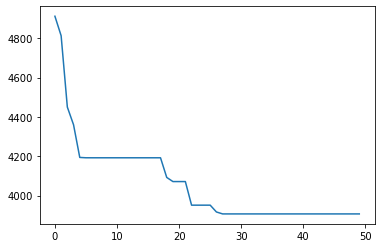

In [73]:
print(MinCost)
plt.plot(MinCost)

In [ ]:
3858.98525239

In [ ]:
3938.16146475

In [ ]:
print(MinCost)
plt.plot(MinCost)